# Figure 2 plotter

### This script plots the atmospheric soundings (ECM + Radiosonde) for the super cold BT
#### Also overlays the estimated anvil temperature and OT temperature from VIIRS


Sounding is 00Z on 29th Dec 2018 from PTPN Ponape

http://www.weather.uwyo.edu/cgi-bin/sounding?region=pac&TYPE=TEXT%3ALIST&YEAR=2018&MONTH=12&FROM=2900&TO=2912&STNM=91348

Note: This station is quite some distance from the cold BT, but is the closest available.

Note2: The 00Z instead of 12Z sounding is used, despite 12Z being closer in time, as the latter cuts out at 17km.

In [8]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
import Meteo_Scripts.proc_prof as pp
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import metpy

<ipython-input-8-6b9cfde6fe64>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


In [2]:
# File locations
sonde_f = '../data/sonde.csv'

# Subsetted ERA5 (input + output)
infile_ml = '../data/Meteo/ML.nc'
infile_sfc = '../data/Meteo/SFC.nc'

In [3]:
# Some important, empirical, numbers

# Storm anvil estimated temp from VIIRS
anvil_viirs = 178.5

# Anvil estimated temp from AHI
anvil_ahi = 181.5

# Cold BT position
minbt_lat = -3.2609048
minbt_lon = 163.2608
minbt_date = datetime(2018, 12, 29, 13, 38, 0)

# OT min temperature from VIIRS-I5 band
ot_mintemp = 161.95508

# Scale factor for altitude, converts meters into km
y_scalefac = 1. / 1000.

# Lapse rates from various measures
# From Griffin + Bedka: https://journals.ametsoc.org/doi/full/10.1175/JAMC-D-15-0170.1
laps_1 = -7.34
# Dry and Wet from: https://www.researchgate.net/profile/Jan_Kanak/publication/269100731_MATURE_CONVECTIVE_STORMS_AND_THEIR_OVERSHOOTING_TOPS_OVER_CENTRAL_EUROPE_-_OVERSHOOTING_TOP_HEIGHT_ANALYSIS_FOR_SUMMERS_2009-2011/links/54854bd10cf24356db60e848/MATURE-CONVECTIVE-STORMS-AND-THEIR-OVERSHOOTING-TOPS-OVER-CENTRAL-EUROPE-OVERSHOOTING-TOP-HEIGHT-ANALYSIS-FOR-SUMMERS-2009-2011.pdf
laps_2 = -9.8
laps_3 = -5.5
# From ECMWF profile, below trop
laps_4 = -6.9
# From nearest radiosonde: http://www.weather.uwyo.edu/cgi-bin/sounding?region=pac&TYPE=TEXT%3ALIST&YEAR=2019&MONTH=11&FROM=3000&TO=3000&STNM=91408
laps_5 = -7.2

# OT alt from parallax
ot_par_alt = 20.509890299426297

In [4]:
# Load the temperature profiles

# Sonde data 
# Temperatures in Celcius, convert to Kelvin
sonde_data = pd.read_csv(sonde_f)
sonde_data['TEMP'] = sonde_data['TEMP'] + 273.15


# ERA5 / ECMWF data
la_pt, lo_pt, ec_skint, ec_sp, ec_u10, ec_v10 = pp.get_sfc(infile_sfc, minbt_lat, minbt_lon)
ec_q, ec_tmp, ec_geop, ec_ozone, n_levels_ec = pp.get_ml(infile_ml, la_pt, lo_pt)

# Geopotential is only at surface, rest of array is masked
ec_geop = ec_geop[0]

# Now compute geopotential height
ec_gh = pp.compute_geop(ec_q, ec_tmp, ec_sp, ec_geop, n_levels_ec)


ecmw_data = pd.DataFrame()
ecmw_data['Altitude'] = ec_gh
ecmw_data['Temperature'] = ec_tmp
ecmw_data['Specific_Humidity'] = ec_q

C:\Users\EUMETCAST#\PycharmProjects\Supercold_BT_Paper\Scripts\Meteo_Scripts\proc_prof.py:57: RuntimeWarning: divide by zero encountered in log
  dlogp = np.log(philevp1 / philev)


In [5]:
# Find tropopause in the ECMWF data
# This doesn't look for double tropopauses or low level inversions. It simply assumes coldest value is tropopause.
# In general, not a good assumption - but for the simple cases we look at here it works nicely.
ecm_trop_temp = np.nanmin(ecmw_data['Temperature'])
pt = ecmw_data.index[ecmw_data['Temperature'] == ecm_trop_temp].tolist()
ecm_trop_alt = ecmw_data['Altitude'][pt].values[0]  * y_scalefac

print(f"Tropopause temperature: {ecm_trop_temp:5.2f}K")
print(f"Tropopause altitude:    {ecm_trop_alt:5.2f}km")

Tropopause temperature: 174.93K
Tropopause altitude:    18.46km


In [6]:
ot_alt_1 = pp.make_prof_temp(ecm_trop_temp, ecm_trop_alt, ot_mintemp, laps_1)
ot_alt_2 = pp.make_prof_temp(ecm_trop_temp, ecm_trop_alt, ot_mintemp, laps_2)
ot_alt_3 = pp.make_prof_temp(ecm_trop_temp, ecm_trop_alt, ot_mintemp, laps_3)
ot_alt_4 = pp.make_prof_temp(ecm_trop_temp, ecm_trop_alt, ot_mintemp, laps_4)
ot_alt_5 = pp.make_prof_temp(ecm_trop_temp, ecm_trop_alt, ot_mintemp, laps_5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


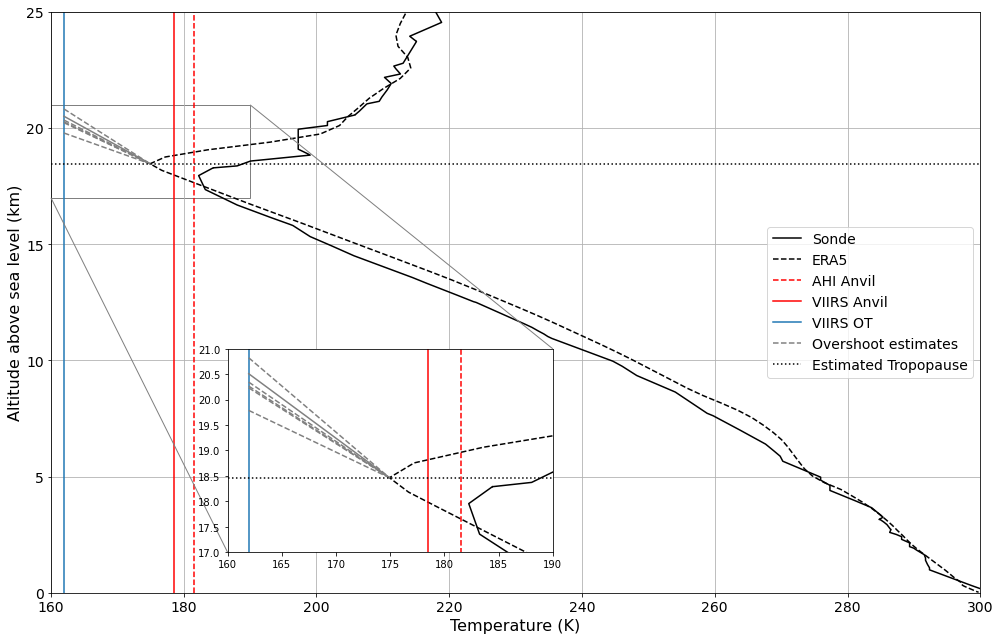

In [34]:
fig_ymin = 0 * y_scalefac
fig_ymax = 25000 * y_scalefac

fig_xmin = 160
fig_xmax = 300

fig, ax = plt.subplots(1,1, figsize=(14,9))

# Plot sonde
ax.plot(sonde_data['TEMP'],
        sonde_data['HGHT'] * y_scalefac,
        label='Sonde',
        c='black')
# Plot ECMWF
ax.plot(ecmw_data['Temperature'],
        ecmw_data['Altitude'] * y_scalefac,
        label='ERA5',
        c='black',
        linestyle='dashed')

# Plot estimated anvil
ax.plot((anvil_ahi, anvil_ahi),
        (fig_ymin, fig_ymax),
        label='AHI Anvil',
        c='red',
        linestyle='dashed')
ax.plot((anvil_viirs, anvil_viirs),
        (fig_ymin, fig_ymax),
        label='VIIRS Anvil',
        c='red')
ax.plot((ot_mintemp, ot_mintemp),
        (fig_ymin, fig_ymax),
        label='VIIRS OT')

# Plot some lapse rates for the overshoot
ax.plot((ot_mintemp, ecm_trop_temp), (ot_alt_1, ecm_trop_alt), c='grey', linestyle='dashed', label='Overshoot estimates')
ax.plot((ot_mintemp, ecm_trop_temp), (ot_alt_2, ecm_trop_alt), c='grey', linestyle='dashed')
ax.plot((ot_mintemp, ecm_trop_temp), (ot_alt_3, ecm_trop_alt), c='grey', linestyle='dashed')
ax.plot((ot_mintemp, ecm_trop_temp), (ot_alt_4, ecm_trop_alt), c='grey', linestyle='dashed')
ax.plot((ot_mintemp, ecm_trop_temp), (ot_alt_5, ecm_trop_alt), c='grey', linestyle='dashed')
ax.plot((ot_mintemp, ecm_trop_temp), (ot_par_alt, ecm_trop_alt), c='grey', linestyle='solid')



# Plot tropopause alt
ax.plot((fig_xmin, fig_xmax), (ecm_trop_alt, ecm_trop_alt), c='black', linestyle='dotted', label = 'Estimated Tropopause')

ax.set_xlim(fig_xmin, fig_xmax)
ax.set_ylim(fig_ymin, fig_ymax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Altitude above sea level (km)', fontsize=16)
leg = ax.legend(fontsize=14)
plt.tight_layout()

# Set up an inset axis to display the overshoot region in more detail
ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.19, 0.07, 0.35, 0.35])
ax2.set_axes_locator(ip)
ax2.set_xlim(160, 190)
ax2.set_ylim(17, 21)


# Plot sonde
ax2.plot(sonde_data['TEMP'],
        sonde_data['HGHT'] * y_scalefac,
        label='Sonde',
        c='black')
# Plot ECMWF
ax2.plot(ecmw_data['Temperature'],
        ecmw_data['Altitude'] * y_scalefac,
        label='ERA5',
        c='black',
        linestyle='dashed')

# Plot estimated anvil
ax2.plot((anvil_ahi, anvil_ahi),
        (fig_ymin, fig_ymax),
        label='AHI Anvil',
        c='red',
        linestyle='dashed')
ax2.plot((anvil_viirs, anvil_viirs),
        (fig_ymin, fig_ymax),
        label='VIIRS Anvil',
        c='red')
ax2.plot((ot_mintemp, ot_mintemp),
        (fig_ymin, fig_ymax),
        label='VIIRS OT')

# Plot some lapse rates for the overshoot
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_alt_1, ecm_trop_alt), c='grey', linestyle='dashed')
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_alt_2, ecm_trop_alt), c='grey', linestyle='dashed')
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_alt_3, ecm_trop_alt), c='grey', linestyle='dashed')
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_alt_4, ecm_trop_alt), c='grey', linestyle='dashed')
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_alt_5, ecm_trop_alt), c='grey', linestyle='dashed')
ax2.plot((ot_mintemp, ecm_trop_temp), (ot_par_alt, ecm_trop_alt), c='grey', linestyle='solid')

# Plot tropopause alt
ax2.plot((fig_xmin, fig_xmax), (ecm_trop_alt, ecm_trop_alt), c='black', linestyle='dotted', label = 'Estimated Tropopause')

# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax, ax2, loc1=3, loc2=1, fc="none", ec='0.5')

plt.savefig('../Figures/Figure_2.png', bbox_inches='tight', facecolor='white')
plt.savefig('../Figures/Figure_2.eps', format='eps', bbox_inches='tight', facecolor='white')

In [14]:
ot_alts = [ot_alt_1,
           ot_alt_2,
           ot_alt_3,
           ot_alt_4,
           ot_alt_5]
ot_over = [ot_alt_1-ecm_trop_alt,
           ot_alt_2-ecm_trop_alt,
           ot_alt_3-ecm_trop_alt,
           ot_alt_4-ecm_trop_alt,
           ot_alt_5-ecm_trop_alt]
print(f'Tropopause altitude: {ecm_trop_alt:5.2f}km\n')

print("OT Characteristics in km")
print("Var       | Minimum  |  Mean  |  Maximum")
print(f"Altitude  | {np.nanmin(ot_alts):5.2f}    |  {np.nanmean(ot_alts):5.2f} |  {np.nanmax(ot_alts):5.2f}")
print(f"Overshoot |{np.nanmin(ot_over):5.2f}     | {np.nanmean(ot_over):5.2f}  | {np.nanmax(ot_over):5.2f}")

Tropopause altitude: 18.46km

OT Characteristics in km
Var       | Minimum  |  Mean  |  Maximum
Altitude  | 19.79    |  20.29 |  20.82
Overshoot | 1.32     |  1.83  |  2.36
